### some imports

In [251]:
import pandas as pd
import numpy as np
from glob import glob
import random
import shutil
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import PIL

In [252]:
root_dir = os.getcwd()+'/root'
annot_dir = os.path.join(root_dir, 'annotations')
img_dir = os.path.join(root_dir, 'images')

### get information for all the face images

In [253]:
dataset = {'filename':[],
           'mask_or_not':[],
           'width':[],
           'height':[],
           'xmin':[],
           'ymin':[],
           'xmax':[],
           'ymax':[]
           }

In [254]:
for annot in glob(annot_dir+'/*.xml'):
    tree = ET.parse(annot)
    for element in tree.iter(): # iterate info for all the faces from all the images
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag:
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))
        
        if 'object' in element.tag:
            for attribute in list(element):
                if 'name' in attribute.tag:
                    name = attribute.text
                    dataset['mask_or_not']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height]
                    dataset['filename']+=[annot.split('/')[-1][0:-4]]
                
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            dataset['ymin']+=[ymin]
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            dataset['xmax']+=[xmax]
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            dataset['ymax']+=[ymax]

In [255]:
df = pd.DataFrame(dataset)
df.shape

(4072, 8)

In [256]:
df.head(5)

,filename,mask_or_not,width,height,xmin,ymin,xmax,ymax
0,maksssksksss299,without_mask,301,400,62,194,160,320
1,maksssksksss528,without_mask,301,400,43,169,149,308
2,maksssksksss272,mask_weared_incorrect,275,400,48,107,218,304
3,maksssksksss514,with_mask,400,267,28,78,43,99
4,maksssksksss514,with_mask,400,267,160,66,176,83


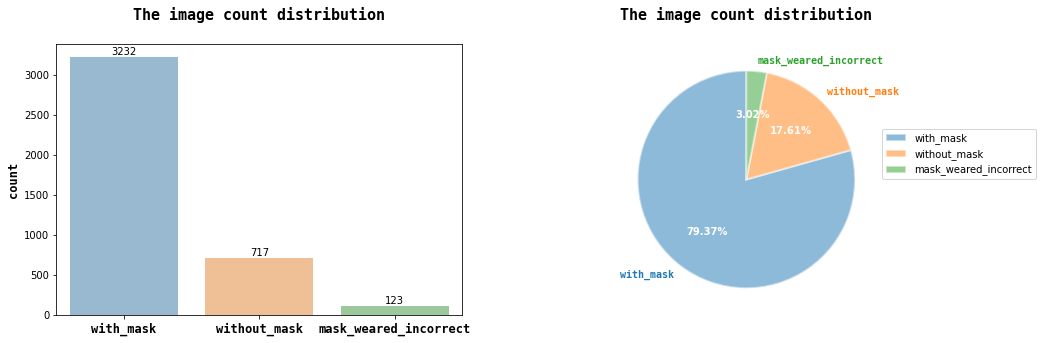

In [257]:
fig,axes = plt.subplots(1,2,figsize=(16,5))
sns.barplot(data=df['mask_or_not'].value_counts().reset_index(), x='index', y='mask_or_not',ax=axes[0], alpha=0.5)
for i in axes[0].get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
    i.set_size(12)
for j in axes[0].containers:
    axes[0].bar_label(j)
    
axes[0].set_xlabel('')
axes[0].set_ylabel('count', font='monospace', weight='semibold', size=12)
axes[0].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15)

patches, texts, pcts = axes[1].pie(df['mask_or_not'].value_counts().reset_index()['mask_or_not'], labels=df['mask_or_not'].value_counts().reset_index()['index'], wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%');
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    patch.set_alpha(0.5)
for j in pcts:
    j.set_size(10)
    j.set_color('white')
    j.set_weight('semibold')
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].legend(loc=[1,0.5])
axes[1].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15);

In [258]:
scale = {'with_mask':0, 'without_mask':1, 'mask_weared_incorrect':2}

In [259]:
df['classes'] = df['mask_or_not'].replace(scale)

In [260]:
df.head()

,filename,mask_or_not,width,height,xmin,ymin,xmax,ymax,classes
0,maksssksksss299,without_mask,301,400,62,194,160,320,1
1,maksssksksss528,without_mask,301,400,43,169,149,308,1
2,maksssksksss272,mask_weared_incorrect,275,400,48,107,218,304,2
3,maksssksksss514,with_mask,400,267,28,78,43,99,0
4,maksssksksss514,with_mask,400,267,160,66,176,83,0


### create the all the files

In [261]:
base_dir = os.path.join('Mask_Detection')
train_dir = os.path.join(base_dir, 'train')
train_imgs_dir = os.path.join(train_dir, 'images')
train_labels_dir = os.path.join(train_dir, 'labels')

validation_dir = os.path.join(base_dir, 'validation')
validation_imgs_dir = os.path.join(validation_dir, 'images')
validation_labels_dir = os.path.join(validation_dir, 'labels')

test_dir = os.path.join(base_dir, 'test')
test_imgs_dir = os.path.join(test_dir, 'images')
test_labels_dir = os.path.join(test_dir, 'labels')

In [262]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [263]:
create_dir(base_dir)

create_dir(train_dir)
create_dir(train_imgs_dir)
create_dir(train_labels_dir)

create_dir(validation_dir)
create_dir(validation_imgs_dir)
create_dir(validation_labels_dir)

create_dir(test_dir)
create_dir(test_imgs_dir)
create_dir(test_labels_dir)

### split the data

In [264]:
all_imgs = os.listdir(img_dir)
print(f'There are totally {len(all_imgs)} images ')

There are totally 853 images 


In [265]:
train, test = train_test_split(all_imgs, test_size=0.1)
train, validation = train_test_split(train, test_size=0.15)

In [266]:
print(f'There are {len(train)} images in the train set\n')
print(f'There are {len(validation)} images in the train set\n')
print(f'There are {len(test)} images in the train set')

There are 651 images in the train set

There are 116 images in the train set

There are 86 images in the train set


### copy the images to the splited files

In [267]:
def copy_images(source_path, destination_path, copied_images):
    for img in copied_images:
        image = PIL.Image.open(os.path.join(source_path, img))
        resized = image.resize((640,480))
        _ = resized.save(os.path.join(destination_path, img))

In [268]:
copy_images(img_dir,train_imgs_dir, train)
copy_images(img_dir,validation_imgs_dir, validation)
copy_images(img_dir,test_imgs_dir, test)

In [269]:
print(f'There are {len(os.listdir(train_imgs_dir))} images in the train set\n')
print(f'There are {len(os.listdir(validation_imgs_dir))} images in the train set\n')
print(f'There are {len(os.listdir(test_imgs_dir))} images in the train set') 
# as we can see now we have splited the images data

There are 651 images in the train set

There are 116 images in the train set

There are 86 images in the train set


### 

Now, we need to resize the annotation box, because here change the image size we can change annotation box size, and find the center of the coordinates

x = (new_x/older_x)*x

In [270]:
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df.head()

,filename,mask_or_not,width,height,xmin,ymin,xmax,ymax,classes
0,maksssksksss299,without_mask,301,400,131.827243,232.800000,340.199336,384.000000,1
1,maksssksksss528,without_mask,301,400,91.428571,202.800000,316.810631,369.600000,1
2,maksssksksss272,mask_weared_incorrect,275,400,111.709091,128.400000,507.345455,364.800000,2
3,maksssksksss514,with_mask,400,267,44.800000,140.224719,68.800000,177.977528,0
4,maksssksksss514,with_mask,400,267,256.000000,118.651685,281.600000,149.213483,0


In [271]:
df.dtypes

filename        object
mask_or_not     object
width            int64
height           int64
xmin           float64
ymin           float64
xmax           float64
ymax           float64
classes          int64
dtype: object

In [272]:
df[['xmin', 'ymin', 'xmax', 'ymax']] = df[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)

In [273]:
W=640
H=480

In [274]:
df['x_center'] = (df['xmin']+df['xmax'])/(2*W)
df['y_center'] = (df['ymin']+df['ymax'])/(2*H)
df['box_width'] = (df['xmax']-df['xmin'])/W
df['box_height'] = (df['ymax']-df['ymin'])/H

In [275]:
df = df.astype(str)

In [276]:
df.dtypes

filename       object
mask_or_not    object
width          object
height         object
xmin           object
ymin           object
xmax           object
ymax           object
classes        object
x_center       object
y_center       object
box_width      object
box_height     object
dtype: object

In [277]:
def copy_label(label_list, destination_path):
    for filename in [x.split('.')[0] for x in label_list]:
        data = df[df['filename']==filename]
        
        text_list = []
        for index, row in data.iterrows():
            text_list.append(row['classes']+' '+row['x_center']+' '+row['y_center']+' '+row['box_width']+' '+row['box_height'])
            
            text = '\n'.join(text_list)
            with open (os.path.join(destination_path, filename+'.txt'),'w') as file:
                file.write(text)  

In [278]:
copy_label(train, train_labels_dir)
copy_label(validation, validation_labels_dir)
copy_label(test, test_labels_dir)

In [279]:
print(f'There are {len(os.listdir(train_labels_dir))} images in the train set\n')
print(f'There are {len(os.listdir(validation_labels_dir))} images in the train set\n')
print(f'There are {len(os.listdir(test_labels_dir))} images in the train set') 

There are 651 images in the train set

There are 116 images in the train set

There are 86 images in the train set


In [287]:
yaml_file = """names: 
- with_mask 
- without_mask 
- mask_weared_incorrect
nc: 3
test: /Users/david/Desktop/machine learning/Python Machine Learning books/Python Artificial Intelligence Projects for Beginners/Detecting masks with yolo v8/Mask_Detection/test
train: /Users/david/Desktop/machine learning/Python Machine Learning books/Python Artificial Intelligence Projects for Beginners/Detecting masks with yolo v8/Mask_Detection/train
val: /Users/david/Desktop/machine learning/Python Machine Learning books/Python Artificial Intelligence Projects for Beginners/Detecting masks with yolo v8/Mask_Detection/validation         
"""

with open('Mask_Detection/data.yaml', 'w') as f:
    f.write(yaml_file)

In [285]:
pip install ultralytics

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [286]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output
! yolo checks

Ultralytics YOLOv8.0.25 🚀 Python-3.10.1 torch-1.13.1 CPU
Setup complete ✅ (8 CPUs, 8.0 GB RAM, 105.9/112.7 GB disk)


In [1]:
! yolo task=detect mode=train model=yolov8x.pt data='/Users/david/Desktop/machine learning/Python Machine Learning books/Python Artificial Intelligence Projects for Beginners/Detecting masks with yolo v8/Mask_Detection/data.yaml' epochs=20 imgsz=640

100%|████████████████████████████████████████| 137M/137M [01:49<00:00, 1.32MB/s]
WARNING ⚠️ 'task=detect' conflicts with segment model yolov8x-seg.pt. Inheriting 'task=segment' from yolov8x-seg.pt and ignoring 'task=detect'.
Ultralytics YOLOv8.0.25 🚀 Python-3.10.1 torch-1.13.1 CPU
yolo/engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=/Users/david/Desktop/machine learning/Python Machine Learning books/Python Artificial Intelligence Projects for Beginners/Detecting masks with yolo v8/Mask_Detection/data.yaml, epochs=20, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, so